# **Traffic Datasets Preprocessing**

In [1]:
%load_ext autoreload
%autoreload 2


import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime, timedelta
from utils import *

datasets_folder = './datasets'
starting_date = datetime(2019,1,1)

## **Data Reading**

For the Traffic data we are provided with the measurements and the corresponding accuracy values. Each year has its own data, so we merge all the `csv`s in the corresponding dataframes.

In [2]:
traffic_folder = os.path.join(datasets_folder,'traffic')

measurements_df = merge_csv_to_dataframe(os.path.join(traffic_folder, 'readings'), sep=';')
accuracies_df = merge_csv_to_dataframe(os.path.join(traffic_folder, 'accuracies'), sep=';')

display(measurements_df.head(3))
display(accuracies_df.head(3))

Merged 6 CSV files
Merged 6 CSV files


,data,codice spira,00:00-01:00,01:00-02:00,02:00-03:00,03:00-04:00,04:00-05:00,05:00-06:00,06:00-07:00,07:00-08:00,...,stato,codimpsem,direzione,angolo,longitudine,latitudine,geopoint,ID_univoco_stazione_spira,Giorno della settimana,giorno settimana
0,2019-01-01,0.127 1.4 2 1,120,142,119,70,59,31,19,38,...,A,318.0,S,170.0,11.347424,44.500815,"44.5008152038968, 11.3474244254298",15.0,Martedì,NaN
1,2019-01-01,0.127 1.12 8 1,59,68,72,46,29,8,11,19,...,A,316.0,N,350.0,11.338970,44.495251,"44.4952505129043, 11.338970003537",2.0,Martedì,NaN
2,2019-01-01,0.127 1.15 6 1,37,31,33,27,13,8,15,16,...,A,324.0,S,168.0,11.343443,44.490027,"44.4900271601578, 11.3434427397635",7.0,Martedì,NaN


,data,codice spira,00:00-01:00,01:00-02:00,02:00-03:00,03:00-04:00,04:00-05:00,05:00-06:00,06:00-07:00,07:00-08:00,...,14:00-15:00,15:00-16:00,16:00-17:00,17:00-18:00,18:00-19:00,19:00-20:00,20:00-21:00,21:00-22:00,22:00-23:00,23:00-24:00
0,2019-01-14,4.30 4.96 4 1,100%,100%,100%,100%,100%,100%,100%,100%,...,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%
1,2019-01-14,4.31 4.29 6 1,100%,100%,100%,95%,58%,87%,100%,100%,...,83%,91%,100%,100%,91%,79%,95%,87%,95%,100%
2,2019-01-14,4.31 4.39 4 1,100%,100%,100%,100%,66%,83%,100%,100%,...,100%,100%,100%,100%,100%,100%,100%,100%,100%,100%


Let's check for non-informative columns

In [3]:
print(measurements_df.columns)

Index(['data', 'codice spira', '00:00-01:00', '01:00-02:00', '02:00-03:00',
       '03:00-04:00', '04:00-05:00', '05:00-06:00', '06:00-07:00',
       '07:00-08:00', '08:00-09:00', '09:00-10:00', '10:00-11:00',
       '11:00-12:00', '12:00-13:00', '13:00-14:00', '14:00-15:00',
       '15:00-16:00', '16:00-17:00', '17:00-18:00', '18:00-19:00',
       '19:00-20:00', '20:00-21:00', '21:00-22:00', '22:00-23:00',
       '23:00-24:00', 'id_uni', 'Livello', 'tipologia', 'codice',
       'codice arco', 'codice via', 'Nome via', 'Nodo da', 'Nodo a',
       'ordinanza', 'stato', 'codimpsem', 'direzione', 'angolo', 'longitudine',
       'latitudine', 'geopoint', 'ID_univoco_stazione_spira',
       'Giorno della settimana', 'giorno settimana'],
      dtype='object')


...and we drop a bunch of them:

In [4]:
measurements_df = measurements_df.drop(columns=[
    'id_uni',
    'Livello',
    'tipologia',
    'codice',
    'codice arco',
    'codice via',
    'Nome via',
    'Nodo da',
    'Nodo a',
    'ordinanza',
    'stato',
    'codimpsem',
    'direzione',
    'angolo',
    'longitudine',
    'latitudine',
    'ID_univoco_stazione_spira',
    'Giorno della settimana',
    'giorno settimana'
])

There shouldn't be any missing value in the dataset because they would be labeled as a `0` reading with `0%` accuracy. In any case, the merging might produce missing values, so we safely clean the dataset.

In [5]:
measurements_df = measurements_df.dropna()
measurements_df

,data,codice spira,00:00-01:00,01:00-02:00,02:00-03:00,03:00-04:00,04:00-05:00,05:00-06:00,06:00-07:00,07:00-08:00,...,15:00-16:00,16:00-17:00,17:00-18:00,18:00-19:00,19:00-20:00,20:00-21:00,21:00-22:00,22:00-23:00,23:00-24:00,geopoint
0,2019-01-01,0.127 1.4 2 1,120,142,119,70,59,31,19,38,...,305,292,311,222,161,116,79,67,57,"44.5008152038968, 11.3474244254298"
1,2019-01-01,0.127 1.12 8 1,59,68,72,46,29,8,11,19,...,68,85,101,55,81,64,50,36,27,"44.4952505129043, 11.338970003537"
2,2019-01-01,0.127 1.15 6 1,37,31,33,27,13,8,15,16,...,33,35,34,45,34,49,25,28,14,"44.4900271601578, 11.3434427397635"
3,2019-01-01,0.127 1.18 1 1,22,23,20,16,14,22,34,35,...,41,46,44,51,54,53,27,17,20,"44.4992226472054, 11.338564528943"
4,2019-01-01,0.127 1.18 2 1,119,190,185,130,62,66,47,50,...,150,176,214,158,155,204,119,114,70,"44.4992331807033, 11.3385147346639"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1788560,2024-11-30,4.91 4.36 8 1,213,131,87,52,33,51,96,217,...,531,557,617,633,581,463,259,227,288,"44.4785683027768, 11.3804873332989"
1788561,2024-11-30,4.93 4.92 6 1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"44.4843292671686, 11.3685493809408"
1788562,2024-11-30,4.96 4.92 4 1,75,51,34,12,13,32,50,170,...,241,296,273,245,277,205,156,130,128,"44.4829011144397, 11.371762568121"
1788563,2024-11-30,4.98 4.98 3 1,56,34,19,11,10,20,45,66,...,176,168,189,179,161,102,60,55,81,"44.4689700816957, 11.3852604232066"


## **Accuracies**

Accuracies are expressed as percentage values. We can inspect them.

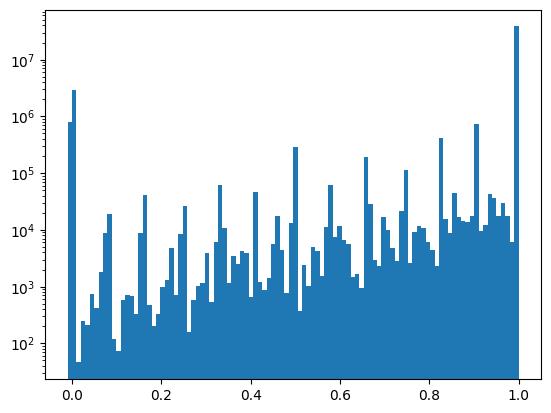

In [6]:
accuracies_df = convert_percentage_to_number(accuracies_df)
v,c=np.unique(np.array(accuracies_df[accuracies_df.columns[2:]]), return_counts=True)
unique_values_array = np.array([v, c]).T
np.set_printoptions(suppress=True)
a=unique_values_array[np.argsort(unique_values_array[:, 0])]
plt.yscale('log')
plt.hist(a[:, 0], bins=len(a[:, 0]), weights=a[:, 1])
plt.show()

A lot of values are -1%, we map them to 0.

In [7]:
def map_values(x):
    if x == -0.01:
        return 0
    return x

accuracies_df = accuracies_df.map(map_values)

## **Applying accuracies**

From the dataset website:

> The dataset reports the percentage accuracy of traffic data detected by the coils for the year 20xx. A percentage of 100% means that the coil correctly detected the data during the reference time slot. 0% means that the coil did not detect any data, for any reason, throughout the duration of the time slot. Intermediate percentages indicate partial detections within the reference time slot.\
The dataset should be used in conjunction with the dataset "Vehicle Detection via Coils - Year 20xx," which contains the traffic data. To determine the accuracy of such traffic data, refer to the combination of the date, code, and specific time slot in this dataset.

From the above description, it looks like that a 50% accuracy means that for half the time the coil *worked*... so if it had a 100% accuracy the actual reading could have been twice as much. Actually, 1% does not necessarely mean that the value should be multiplied by 100.

It is not perfectly clear how these accuracies should be used. If the percentage value only represents the amount of time that the coil registered data throughout the time slot, then it would simply mean that for that amount of time no veichle has passed, instead of the coil not having worked... in this last case accuracies wouldn't be needed to know the actual traffic value, so we choose to consider these accuracies as in the first scenario. In the end, we simply multiply the reading by $1 / accuracy$.

In [8]:
common_cols = measurements_df.columns.intersection(accuracies_df.columns).tolist()

accurate_traffic_df = apply_accuracy_df(measurements_df[common_cols],accuracies_df[common_cols]).reset_index(drop=True)
measurements_df = measurements_df.reset_index(drop=True)
for col in list(set(measurements_df.columns) - set(common_cols)): # add back measurements columns
    accurate_traffic_df[col] = measurements_df[col]

In [9]:
accurate_traffic_df

,data,codice spira,00:00-01:00,01:00-02:00,02:00-03:00,03:00-04:00,04:00-05:00,05:00-06:00,06:00-07:00,07:00-08:00,...,15:00-16:00,16:00-17:00,17:00-18:00,18:00-19:00,19:00-20:00,20:00-21:00,21:00-22:00,22:00-23:00,23:00-24:00,geopoint
0,2019-01-01,0.127 1.4 2 1,120,142,119,70,59,31,19,38,...,305,292,311,222,161,116,79,67,57,"44.5008152038968, 11.3474244254298"
1,2019-01-01,0.127 1.12 8 1,59,68,72,46,29,8,11,19,...,68,85,101,55,81,64,50,36,27,"44.4952505129043, 11.338970003537"
2,2019-01-01,0.127 1.15 6 1,37,31,33,27,13,8,15,19,...,33,35,34,45,34,49,25,28,14,"44.4900271601578, 11.3434427397635"
3,2019-01-01,0.127 1.18 1 1,22,23,20,16,14,24,34,35,...,41,46,44,51,54,53,27,17,20,"44.4992226472054, 11.338564528943"
4,2019-01-01,0.127 1.18 2 1,119,190,185,130,62,72,47,50,...,150,176,214,158,155,204,119,114,70,"44.4992331807033, 11.3385147346639"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1785118,2024-11-30,4.91 4.36 8 1,213,131,87,52,33,51,96,217,...,531,557,617,633,581,463,259,227,288,"44.4785683027768, 11.3804873332989"
1785119,2024-11-30,4.93 4.92 6 1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"44.4843292671686, 11.3685493809408"
1785120,2024-11-30,4.96 4.92 4 1,75,51,34,12,13,32,50,170,...,241,296,273,245,277,205,156,130,128,"44.4829011144397, 11.371762568121"
1785121,2024-11-30,4.98 4.98 3 1,56,34,19,11,10,20,45,66,...,176,168,189,179,161,102,60,55,81,"44.4689700816957, 11.3852604232066"


## **Locality of the measurements**

The coils of the dataset are spread across the city, but the meaningful traffic value for each station is given by the measurements in its surroundings. To filter the traffic measurements, we can use the geopoints of the station and coils and only consider them if the distance is below a certain radius.

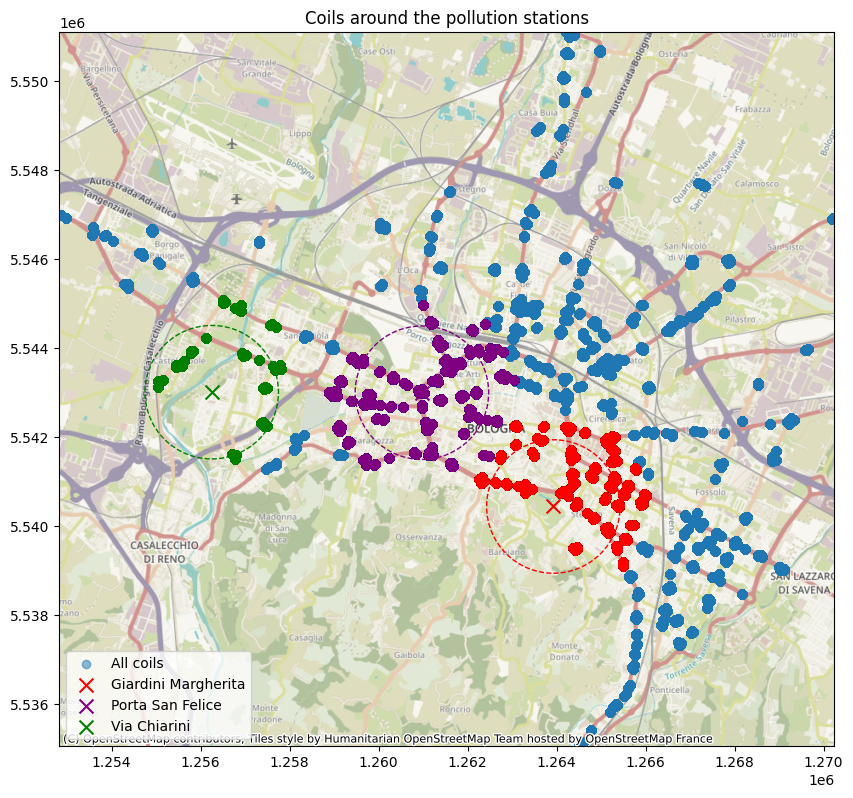

In [10]:
giardini_margherita_geopoint = '44.482671138769533,11.35406170088398'
san_felice_geopoint = '44.499059983334519,11.327526717440112'
chiarini_geopoint = '44.499134335170289,11.285089594971216'

center_points = {
    "Giardini Margherita": giardini_margherita_geopoint,
    "Porta San Felice": san_felice_geopoint,
    "Via Chiarini": chiarini_geopoint
}

radius = 1.5  # km

aux = accurate_traffic_df.copy()
aux['lat'] = aux['geopoint'].apply(lambda x: float(x.split(',')[0]))
aux['lon'] = aux['geopoint'].apply(lambda x: float(x.split(',')[1]))

for distance_function in ( # the results are exactly the same, but ecef_distance is the fastest
    # haversine, 
    # adaptive_haversine, 
    ecef_distance,
    ):
    plt.figure(figsize=(10, 10))

    # Scatter the points
    plt.scatter(aux['lon'], aux['lat'], label="All coils", alpha=0.5)

    colors = ['red', 'purple', 'green']
    for (label, center), color in zip(center_points.items(), colors):
        lat, lon = map(float, center.split(','))
        circle = plt.Circle((lon, lat), radius / 111, color=color, fill=False, linestyle="--")
        plt.scatter(lon, lat, c=color, marker='x', s=100)
        station_traffic = search_close_measurements(aux, center, radius, method=distance_function)
        plt.scatter(station_traffic['lon'], station_traffic['lat'], c=color, alpha=0.7, label=f"{label}")
        plt.gca().add_patch(circle)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(loc='lower left')
    plt.title("Coils around the pollution stations")
    plt.gca().set_aspect('equal', adjustable='box')

    # background map 
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(aux['lon'], aux['lat']), crs="EPSG:4326")
    gdf = gdf.to_crs(epsg=3857) 

    ax.clear()
    plt.scatter(gdf.geometry.x, gdf.geometry.y, label="All coils", alpha=0.5)

    for (label, center), color in zip(center_points.items(), colors):
        lat, lon = map(float, center.split(','))
        center_geom = gpd.GeoSeries([Point(lon, lat)], crs="EPSG:4326").to_crs(epsg=3857)
        cx, cy = center_geom.geometry.x.iloc[0], center_geom.geometry.y.iloc[0]
        circle = plt.Circle((cx, cy), radius * 1000, color=color, fill=False, linestyle="--") 
        plt.scatter(cx, cy, c=color, marker='x', s=100, label=f"{label}")
        station_traffic = search_close_measurements(aux, center, radius, method=distance_function)
        st_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(station_traffic['lon'], station_traffic['lat']), crs="EPSG:4326").to_crs(epsg=3857)
        plt.scatter(st_gdf.geometry.x, st_gdf.geometry.y, c=color, alpha=0.7)
        plt.gca().add_patch(circle)

    ctx.add_basemap(ax, crs="EPSG:3857")
    ax.set_xlim(gdf.total_bounds[[0, 2]])
    ax.set_ylim(gdf.total_bounds[[1, 3]])

    plt.legend(loc='lower left')
    plt.title("Coils around the pollution stations")
    plt.show()

The distances, both for the circle and geo-distances, are not precise cause they are computed using approximated methods. Anyways, their locality is still fine for our needs, it is simply not exactly `radius`km.

## **Create per-hour data from multiple coils**

Let's only consider one station and extract the close-by measurements.

In [11]:
station_traffic = {}
station_traffic['GIARDINI MARGHERITA'] = search_close_measurements(accurate_traffic_df, giardini_margherita_geopoint, radius)
station_traffic['GIARDINI MARGHERITA'] = station_traffic['GIARDINI MARGHERITA'].drop(columns=['geopoint', 'codice spira']) 
station_traffic['GIARDINI MARGHERITA'].head(5)

,data,00:00-01:00,01:00-02:00,02:00-03:00,03:00-04:00,04:00-05:00,05:00-06:00,06:00-07:00,07:00-08:00,08:00-09:00,...,14:00-15:00,15:00-16:00,16:00-17:00,17:00-18:00,18:00-19:00,19:00-20:00,20:00-21:00,21:00-22:00,22:00-23:00,23:00-24:00
2,2019-01-01,37,31,33,27,13,8,15,19,27,...,25,33,35,34,45,34,49,25,28,14
5,2019-01-01,20,55,58,22,15,10,13,8,9,...,20,37,33,33,43,34,44,34,21,9
57,2019-01-01,111,203,179,83,60,43,64,49,55,...,153,205,218,274,233,241,159,94,86,61
64,2019-01-01,23,18,19,23,11,16,18,19,17,...,53,47,42,56,73,88,56,32,25,13
66,2019-01-01,12,35,28,16,10,15,3,0,12,...,33,27,31,47,46,47,27,29,17,14


Inspecting the dataframe, we can notice that we have as many features as the hours of the day. We want to have a single value referring to the traffic hour. To do so, we sum all the traffic measurements from all the coils of that hour.

<Axes: xlabel='Hour'>

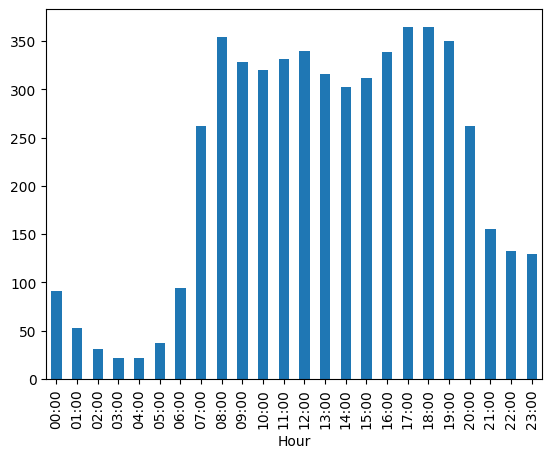

In [12]:
station_traffic_melted = {}
station_traffic_melted['GIARDINI MARGHERITA'] = station_traffic['GIARDINI MARGHERITA'].melt(id_vars=["data"], var_name="Hour", value_name="Traffic_value")
station_traffic_melted['GIARDINI MARGHERITA']['Hour'] = station_traffic_melted['GIARDINI MARGHERITA']['Hour'].apply(lambda x: x.split('-')[0])
station_traffic_melted['GIARDINI MARGHERITA'].groupby('Hour')['Traffic_value'].mean().plot(kind='bar')

From the plot we can see the average traffic data across all the days. As we might expect, during the night the traffic is really low. During clock-in and clock-out hours the traffic peaks.

To proceed, we have to move the columns into rows and sum all the rows with the same index (same date and hour).

In [13]:
s = 'GIARDINI MARGHERITA'
station_traffic_melted[s]['data'] = pd.to_datetime(station_traffic_melted[s]['data'] + ' ' + station_traffic_melted[s]['Hour'])
station_traffic_melted[s] = station_traffic_melted[s].rename(columns={'data': 'Date'})
station_traffic_melted[s] = station_traffic_melted[s].drop(columns=['Hour'])
station_traffic_melted[s] = station_traffic_melted[s].groupby('Date', as_index=False)['Traffic_value'].sum()

In [14]:
station_traffic_melted['GIARDINI MARGHERITA'].head(5)

,Date,Traffic_value
0,2019-01-01 00:00:00,19875
1,2019-01-01 01:00:00,31896
2,2019-01-01 02:00:00,29161
3,2019-01-01 03:00:00,18639
4,2019-01-01 04:00:00,11608


## **Traffic visualization**

We can plot the values, each year in a separate plot:

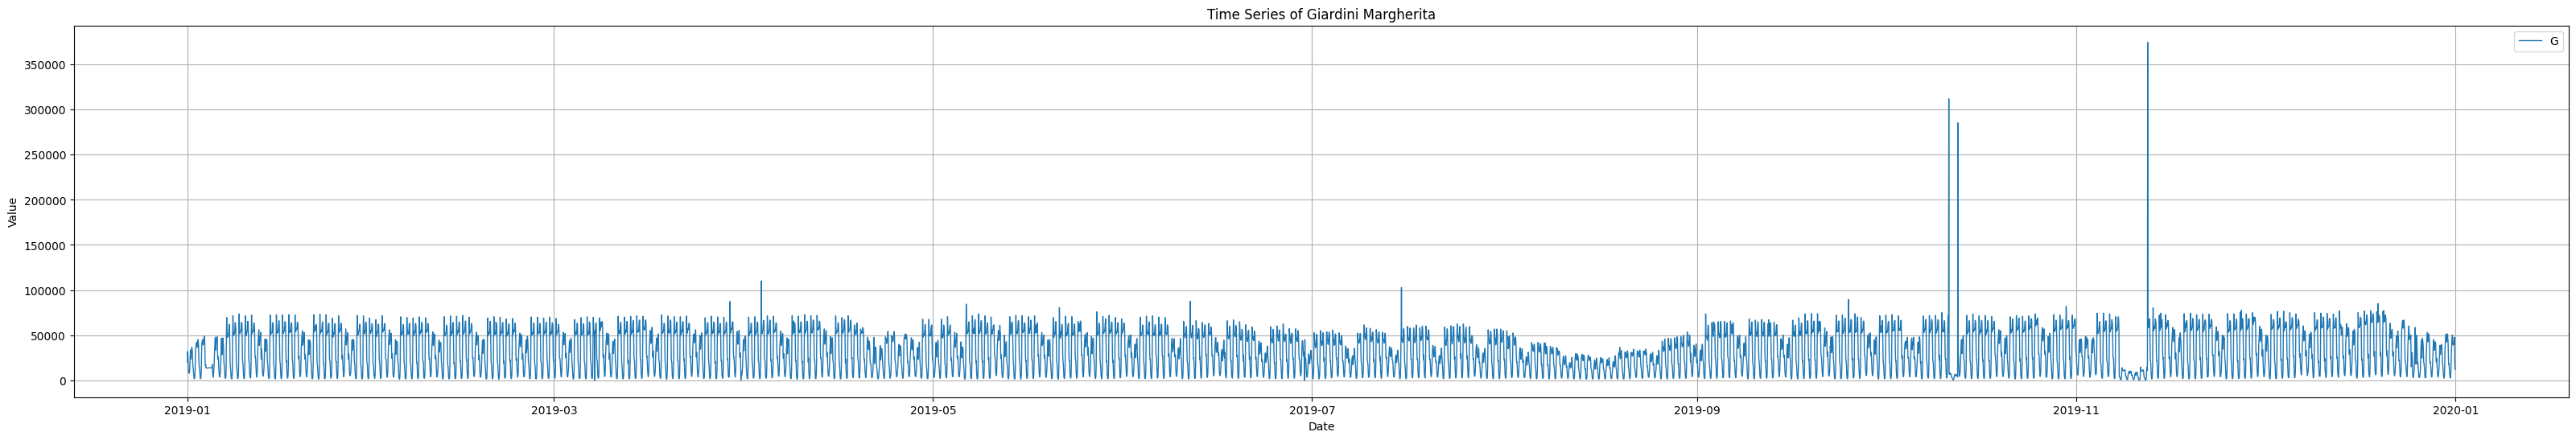

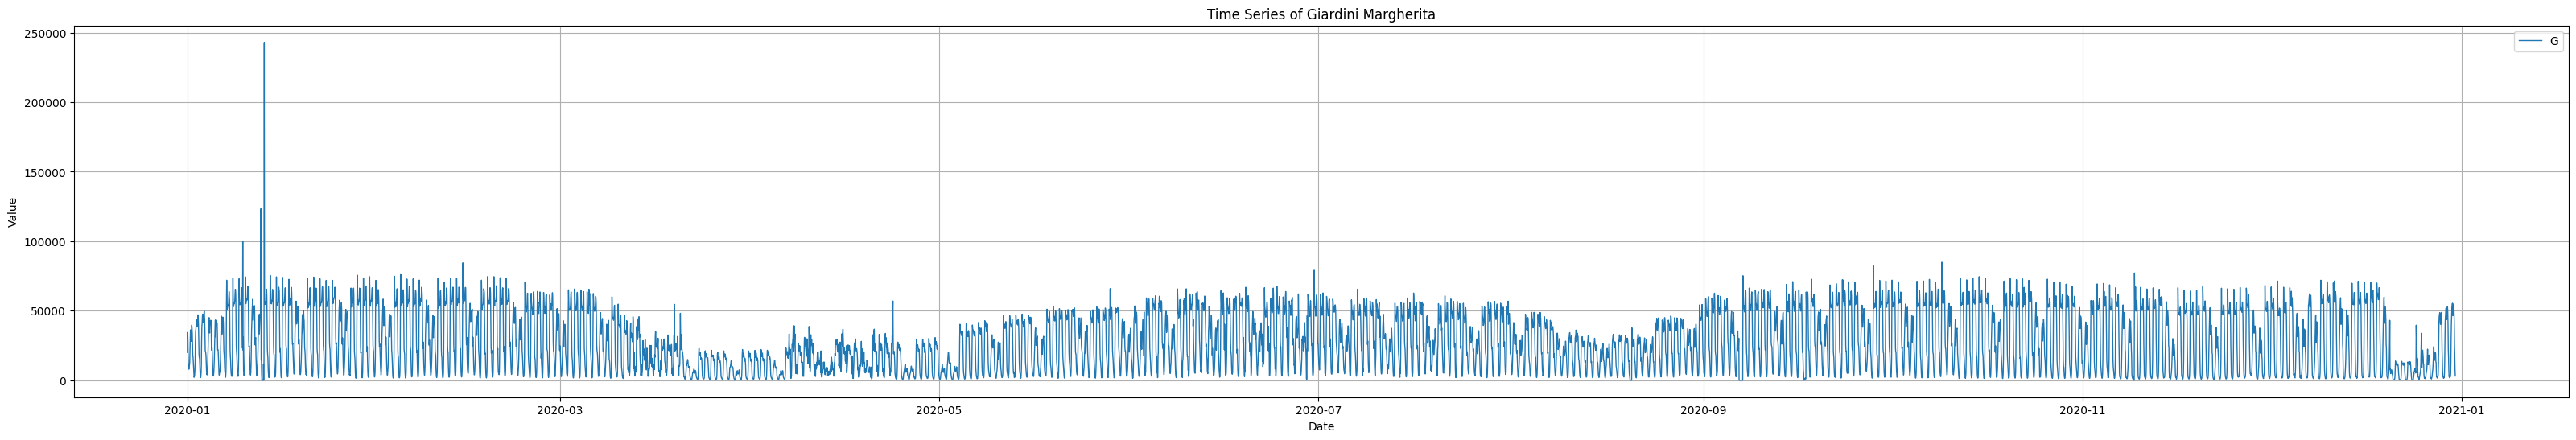

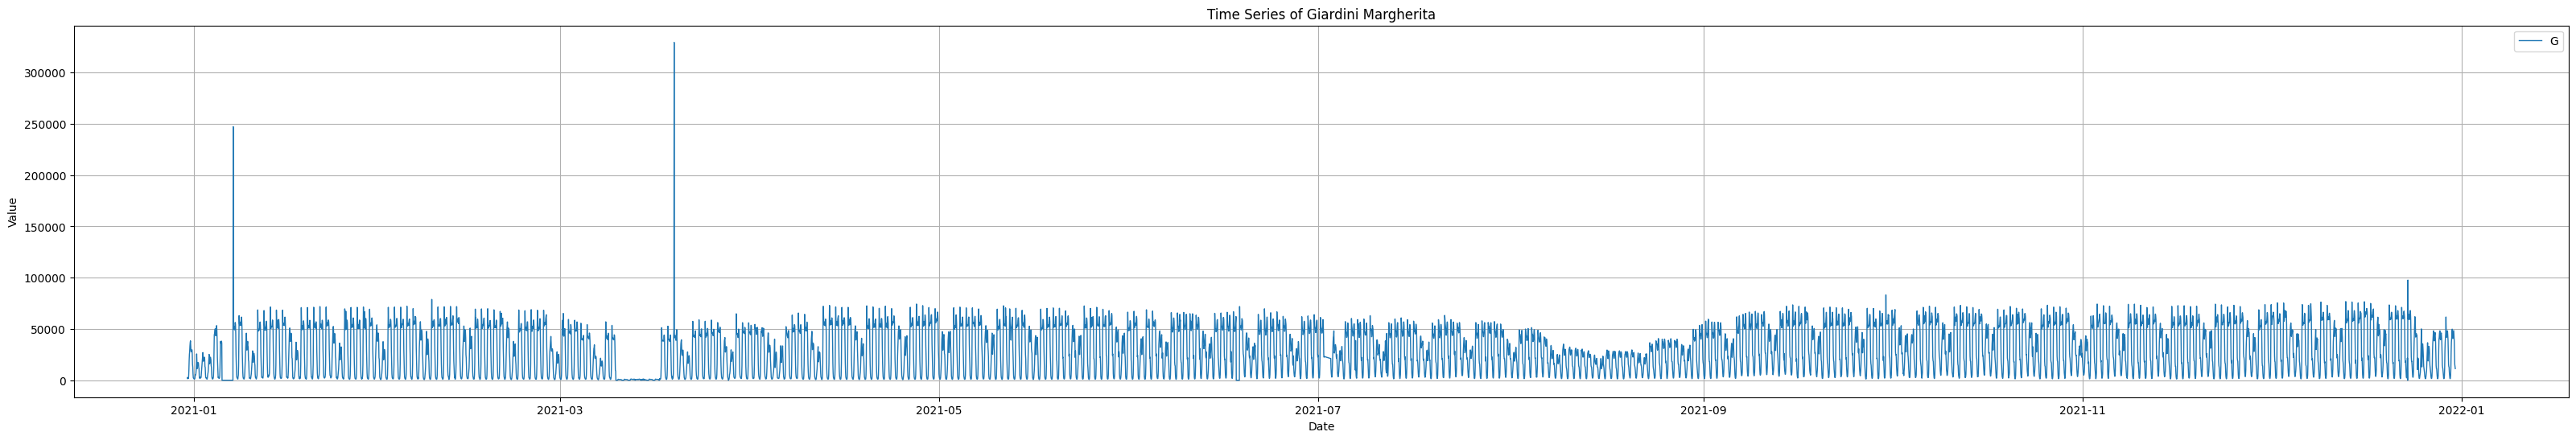

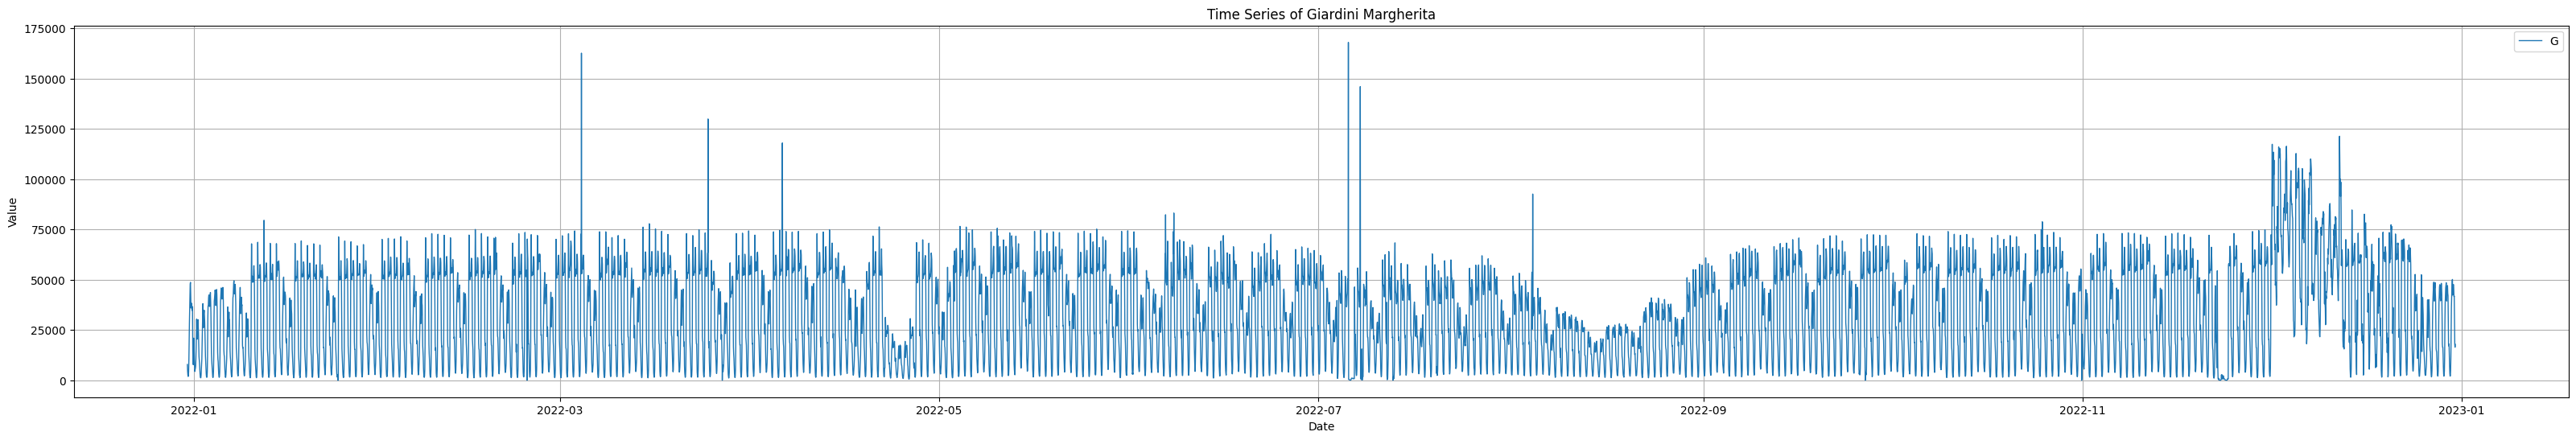

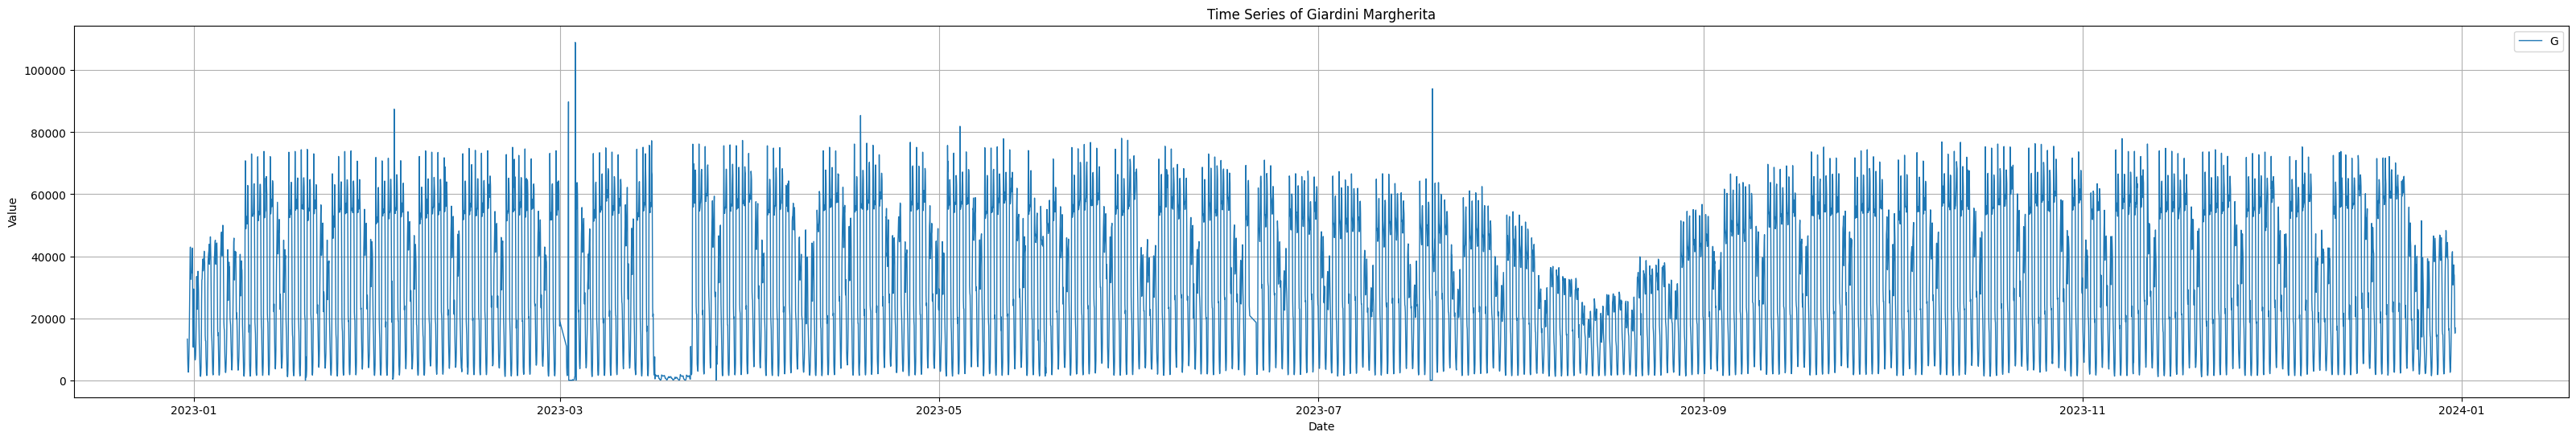

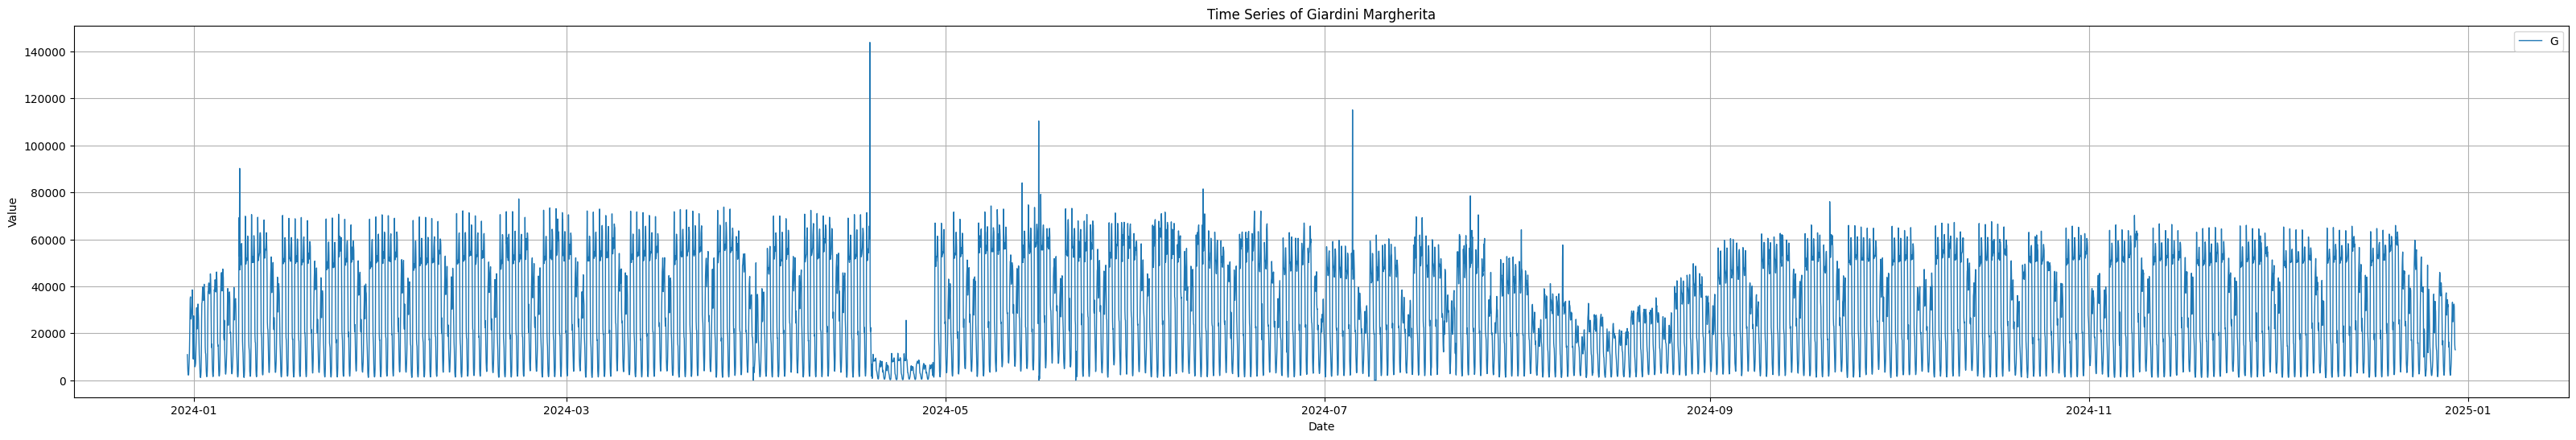

In [15]:
starting_date = datetime(2019,1,1)
ending_date = datetime(2024,12,31,23)
period = timedelta(days=365)
s = 'GIARDINI MARGHERITA'

for i in range((ending_date-starting_date) // period):
    start = starting_date + i*period
    end = min(starting_date + (i + 1) * period, ending_date)
    plot_time_series([station_traffic_melted[s]],  'Traffic_value','Date', "Giardini", start_date=start, end_date=end,  max_rows=500000, title='Giardini Margherita')

Most of the data seems to be continuos, even if sometimes small gaps with really low values appear. Also, there are certain spikes with no clear reason or periodicity.

Missing hours will be filled with zeros, instead of trying to perform forward/backwards filling or average filling.

In [16]:
station_traffic_melted[s].resample('1h', on='Date').max().isna().sum()

Traffic_value    72
dtype: int64

In [17]:
s= 'GIARDINI MARGHERITA'
station_traffic_melted[s] = station_traffic_melted[s].resample('1h', on='Date').mean().reset_index().fillna(0)
station_traffic_melted[s]

,Date,Traffic_value
0,2019-01-01 00:00:00,19875.0
1,2019-01-01 01:00:00,31896.0
2,2019-01-01 02:00:00,29161.0
3,2019-01-01 03:00:00,18639.0
4,2019-01-01 04:00:00,11608.0
...,...,...
52603,2024-12-31 19:00:00,36587.0
52604,2024-12-31 20:00:00,35910.0
52605,2024-12-31 21:00:00,15051.0
52606,2024-12-31 22:00:00,9444.0


In [18]:
station_traffic_melted[s][station_traffic_melted[s]['Traffic_value'] == 0]

,Date,Traffic_value
1573,2019-03-07 13:00:00,0.0
2138,2019-03-31 02:00:00,0.0
4314,2019-06-29 18:00:00,0.0
4315,2019-06-29 19:00:00,0.0
9048,2020-01-13 00:00:00,0.0
...,...,...
48387,2024-07-09 03:00:00,0.0
48388,2024-07-09 04:00:00,0.0
48389,2024-07-09 05:00:00,0.0
48390,2024-07-09 06:00:00,0.0


## **Daily Data**

In order to convert hourly data to daily data to evaluate daily agents, we can:
- Average or sum the values of each day
- Bin them into columns as a feature. For example we might want to pack 8 hours and have the total traffic of 00AM-8AM, 8AM-16PM and 16PM-24PM.

Let's take as example one day of data:

In [19]:
start = datetime(2019,2,1) # in january there is new year eve and data is a bit less representative
end = datetime(2019,2,2)

tmp = station_traffic_melted['GIARDINI MARGHERITA'].set_index('Date')
one_day_df = tmp[(tmp.index>=start)&(tmp.index<end)]
print(f'Number of hours: {len(one_day_df)}')
print(f'Total traffic: {one_day_df.sum()}')
one_day_df.head(5)

Number of hours: 24
Total traffic: Traffic_value    934816.0
dtype: float64


,Traffic_value
Date,
2019-02-01 00:00:00,14191.0
2019-02-01 01:00:00,5996.0
2019-02-01 02:00:00,2639.0
2019-02-01 03:00:00,1903.0
2019-02-01 04:00:00,2465.0


We can try different bin sizes, like the one proposed earlier:

In [20]:
tmp = transform_traffic_to_daily_df(one_day_df, bin_size=8)
print(f'Total traffic: {tmp.sum().sum()}')
tmp

Total traffic: 934816.0


,Traffic_0-7,Traffic_8-15,Traffic_16-0
Date,,,
2019-02-01,101103.0,459847.0,373866.0


...or a sparser one, using 4 hours:

In [21]:
tmp = transform_traffic_to_daily_df(one_day_df, bin_size=4)
print(f'Total traffic: {tmp.sum().sum()}')
tmp

Total traffic: 934816.0


,Traffic_0-3,Traffic_4-7,Traffic_8-11,Traffic_12-15,Traffic_16-19,Traffic_20-0
Date,,,,,,
2019-02-01,24729.0,76374.0,237651.0,222196.0,246079.0,127787.0


*note that the sums hold across the hours*

A reasonable idea is to have morning, noon and night:
- night: 22-6 -> the last 2 hours of the day before plus 00-AM to 06-AM
- morning: 6-14
- noon: 14-22

The 24 hours used are not from the same day, so in hour case we only compose the day using 22 hours (the last 2 hours would be used for the next day)

Since that the hous are not aligned with the start of the day, we can use the `offset` parameter.

In [22]:
tmp = transform_traffic_to_daily_df(one_day_df, bin_size=8, offset=2, dropna=False)
print(f'Total traffic: {tmp.sum().sum()}')
tmp

Total traffic: 934816.0


,Traffic_2-9,Traffic_10-17,Traffic_18-2
Date,,,
2019-01-31,NaN,NaN,20187.0
2019-02-01,211634.0,450432.0,252563.0


Since that the offset is 2, the first two hours of each day are used by the previous day for their last bin.